In [31]:
!pip install tabulate -q


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,f1_score,roc_curve, confusion_matrix
import seaborn as sns
from tabulate import tabulate

In [33]:
import joblib
from sklearn.ensemble import GradientBoostingClassifier
from joblib import dump, load

In [34]:
df = pd.read_csv('diabetes.csv')

In [35]:
df.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


In [36]:
df.tail()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
14995,1490300,10,65,60,46,177,33.512468,0.148327,41,1
14996,1744410,2,73,66,27,168,30.132636,0.862252,38,1
14997,1742742,0,93,89,43,57,18.690683,0.427049,24,0
14998,1099353,0,132,98,18,161,19.791645,0.302257,23,0
14999,1386396,3,114,65,47,512,36.215437,0.147363,34,1


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


In [38]:
df.isna().sum().sum()

0

In [39]:
df.duplicated().sum()

0

# Preprocessing

In [40]:
# Non standardized
X = df.drop(['Diabetic','PatientID'],axis=1)
y = df['Diabetic']

In [41]:
# Our Scaler
scalers = {
    "Non-standardize" : None, # No scaling
    "Standard Scaler": StandardScaler(), # Standardize using Min-Max Scaler
    "Min-Max Scaler": MinMaxScaler(), # Standardize using Min-Max Scaler
}

In [42]:
# Split 75:25 train test split
test_split = 0.25

# Our seed for reproducability
seed = 42
np.random.seed(seed)
random.seed(seed)

# Our split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_split,random_state=seed)

# Models
Here we will also do some hyperparameter tuning

In [43]:
# Our Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=3,
    max_features=0.5,
    random_state=seed
)

In [44]:
# Functions to evaluate our model and see the difference between scale
def evaluate_model(X_train,X_test,y_train,y_test,model):

  # Train
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  y_pred_prob = model.predict_proba(X_test)[:, 1]

  # ROC-AUC
  roc_auc = roc_auc_score(y_test, y_pred_prob)
  fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

  # Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)

  # Other metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  return model, y_pred, y_pred_prob, roc_auc,fpr,tpr,cm,accuracy,precision,recall,f1

In [45]:
models = {
    "Gradient Boosting": gb_model,
}

results = {scaler_name: {} for scaler_name in scalers.keys()}

# Evaluation

Here we will test it based on a couple of metrics:
- F1-Score
- ROC AUC Score
- Accuracy
- Precision
- Recall

In [46]:
def print_results(results):
    for scaler_name, scaler_results in results.items():
        print(f"\nResults for {scaler_name}:")
        for model_name, metrics in scaler_results.items():
            print(f"\nModel: {model_name}")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall: {metrics['recall']:.4f}")
            print(f"  F1 Score: {metrics['f1']:.4f}")
            print(f"  ROC AUC: {metrics['roc_auc']:.4f}")

            # Plot ROC Curve
            if metrics['roc_auc'] > 0:
                plt.figure()
                plt.plot(metrics['fpr'], metrics['tpr'], label=f"ROC Curve (AUC = {metrics['roc_auc']:.4f})")
                plt.plot([0, 1], [0, 1], 'k--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve - {model_name} ({scaler_name})')
                plt.legend(loc="lower right")
                plt.show()

            # Plot Confusion Matrix
            plt.figure(figsize=(10, 7))
            sns.heatmap(metrics['cm'], annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=['Predicted Negative', 'Predicted Positive'],
                        yticklabels=['Actual Negative', 'Actual Positive'])
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title(f'Confusion Matrix - {model_name} ({scaler_name})')
            plt.show()

In [47]:
# Table format
def print_results_table(results):
    table = []
    headers = ["Scaler", "Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

    for scaler_name, scaler_results in results.items():
        for model_name, metrics in scaler_results.items():
            table.append([
                scaler_name,
                model_name,
                f"{metrics['accuracy']:.4f}",
                f"{metrics['precision']:.4f}",
                f"{metrics['recall']:.4f}",
                f"{metrics['f1']:.4f}",
                f"{metrics['roc_auc']:.4f}"
            ])

    print(tabulate(table, headers=headers, tablefmt="grid"))

In [48]:
# Train and get metrics
for scaler_name, scaler in scalers.items():
  if scaler is not None:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
  else:
    X_train_scaled = X_train.values
    X_test_scaled = X_test.values
  for model_name, model in models.items():
      metrics = evaluate_model(X_train_scaled, X_test_scaled, y_train, y_test, model)
      results[scaler_name][model_name] = {
          "model": metrics[0],
          "y_pred": metrics[1],
          "y_pred_prob": metrics[2],
          "roc_auc": metrics[3],
          "fpr": metrics[4],
          "tpr": metrics[5],
          "cm": metrics[6],
          "accuracy": metrics[7],
          "precision": metrics[8],
          "recall": metrics[9],
          "f1": metrics[10]
      }


Results for Non-standardize:

Model: Gradient Boosting
  Accuracy: 0.9283
  Precision: 0.9068
  Recall: 0.8724
  F1 Score: 0.8893
  ROC AUC: 0.9804


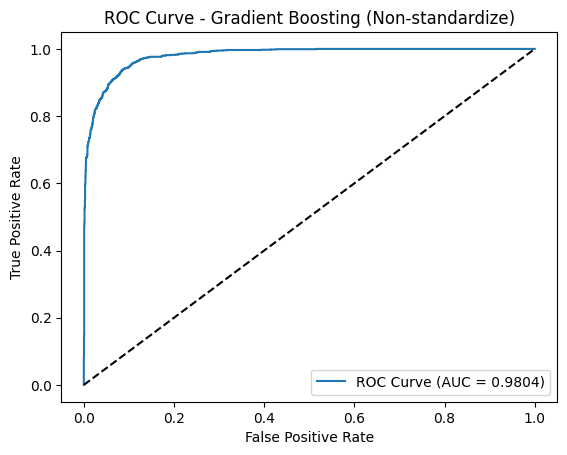

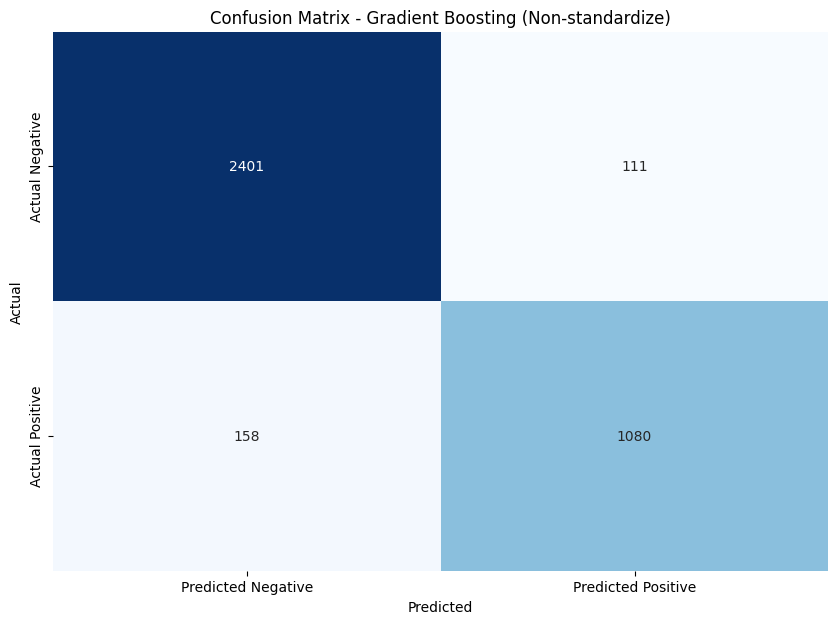


Results for Standard Scaler:

Model: Gradient Boosting
  Accuracy: 0.9283
  Precision: 0.9068
  Recall: 0.8724
  F1 Score: 0.8893
  ROC AUC: 0.9805


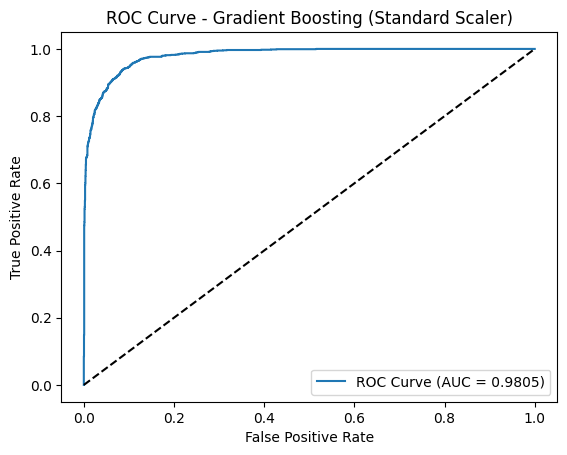

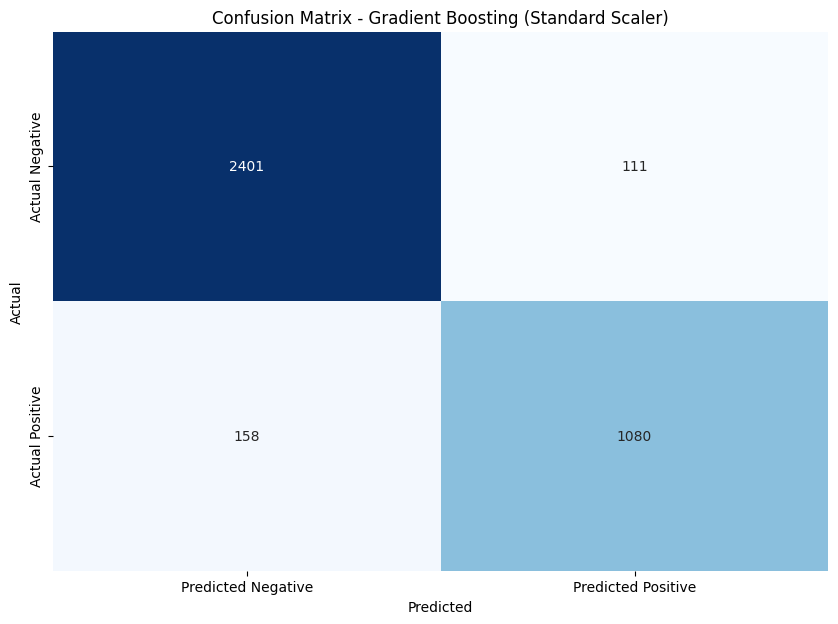


Results for Min-Max Scaler:

Model: Gradient Boosting
  Accuracy: 0.9283
  Precision: 0.9068
  Recall: 0.8724
  F1 Score: 0.8893
  ROC AUC: 0.9804


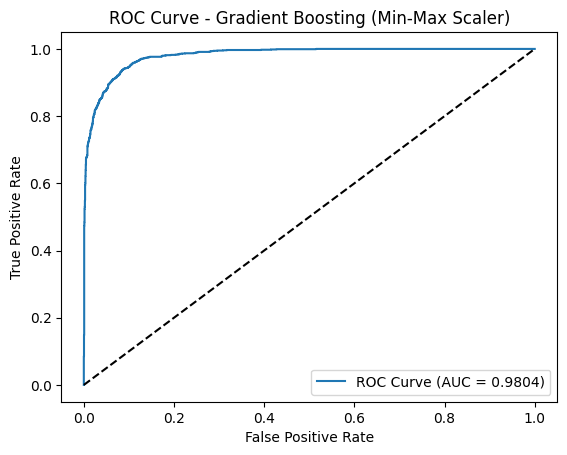

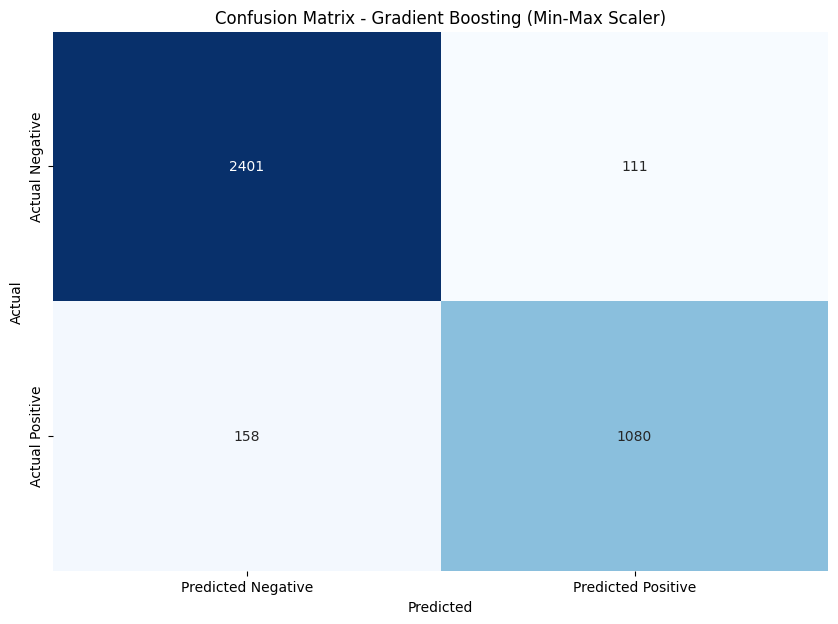

In [49]:
print_results(results)

In [50]:
print_results_table(results)

+-----------------+-------------------+------------+-------------+----------+------------+-----------+
| Scaler          | Model             |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |
+=================+===================+============+=============+==========+============+===========+
| Non-standardize | Gradient Boosting |     0.9283 |      0.9068 |   0.8724 |     0.8893 |    0.9804 |
+-----------------+-------------------+------------+-------------+----------+------------+-----------+
| Standard Scaler | Gradient Boosting |     0.9283 |      0.9068 |   0.8724 |     0.8893 |    0.9805 |
+-----------------+-------------------+------------+-------------+----------+------------+-----------+
| Min-Max Scaler  | Gradient Boosting |     0.9283 |      0.9068 |   0.8724 |     0.8893 |    0.9804 |
+-----------------+-------------------+------------+-------------+----------+------------+-----------+


Our Results

In [51]:
print_results_table(results)

+-----------------+-------------------+------------+-------------+----------+------------+-----------+
| Scaler          | Model             |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |
+=================+===================+============+=============+==========+============+===========+
| Non-standardize | Gradient Boosting |     0.9283 |      0.9068 |   0.8724 |     0.8893 |    0.9804 |
+-----------------+-------------------+------------+-------------+----------+------------+-----------+
| Standard Scaler | Gradient Boosting |     0.9283 |      0.9068 |   0.8724 |     0.8893 |    0.9805 |
+-----------------+-------------------+------------+-------------+----------+------------+-----------+
| Min-Max Scaler  | Gradient Boosting |     0.9283 |      0.9068 |   0.8724 |     0.8893 |    0.9804 |
+-----------------+-------------------+------------+-------------+----------+------------+-----------+


In [52]:
def demo(data, model):
  y_pred = model.predict(data)
  prediction = 'Unfortunately, you have diabetes...' if y_pred else "Congrats! you have no diabetes"
  print(f'prediction: {prediction}')

def askParameters():
  preg = input("How many times were you pregnant?: ")
  plasma = input("Plasma glucose concentration a 2 hours in an oral glucose tolerance test: ")
  dias = input("Diastolic blood pressure (mm Hg): ")
  tricep = input("Triceps skin fold thickness (mm): ")
  serum = input("2-Hour serum insulin (mu U/ml): ")
  bmi = input("Body mass index (weight in kg/(height in m)^2): ")
  diabet = input("Diabetes pedigree function: ")
  age = input("Age (years): ")
  data = pd.DataFrame({
    'Pregnancies': [preg],
    'PlasmaGlucose': [plasma],
    'DiastolicBloodPressure': [dias],
    'TricepsThickness': [tricep],
    'SerumInsulin': [serum],
    'BMI': [bmi],
    'DiabetesPedigree': [diabet],
    'Age': [age]
  }).values
  return data

In [53]:
demo(askParameters(),results['Non-standardize']['Gradient Boosting']['model'])

prediction: Unfortunately, you have diabetes...


In [54]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier()

In [55]:
joblib.dump(model, 'model.pkl')


['model.pkl']